**Machine Learning 2 Project by Rahul Kushwaha, Awanish Kumar and Soham Chatterjee**

(Group 9) Using autoencoder for anamoly detection - One of the challenges in using autoencoders for anamoly detection is that autoencoders tend to reconstruct anamolies while learning what is not an anamoly. In [6], an
autoencoder is proposed that queries a memory module in its latent space,
which restricts the possible reconstructions from the latent space. Implement
the proposed approach of [6] in PyTorch and verify whether the results on the
KDDCUP cybersecurity dataset for anamoly detection can be reproduced.

# **Code for autoencoder**

In [146]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [147]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset,TensorDataset
from sklearn.preprocessing import OneHotEncoder

Features of the dataset

In [148]:
features=['duration',
 'protocol_type',
 'service',
 'flag',
 'src_bytes',
 'dst_bytes',
 'land',
 'wrong_fragment',
 'urgent',
 'hot',
 'num_failed_logins',
 'logged_in',
 'num_compromised',
 'root_shell',
 'su_attempted',
 'num_root',
 'num_file_creations',
 'num_shells',
 'num_access_files',
 'num_outbound_cmds',
 'is_host_login',
 'is_guest_login',
 'count',
 'srv_count',
 'serror_rate',
 'srv_serror_rate',
 'rerror_rate',
 'srv_rerror_rate',
 'same_srv_rate',
 'diff_srv_rate',
 'srv_diff_host_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'dst_host_rerror_rate',
 'dst_host_srv_rerror_rate',
 'class',
 'num_attacks']

Rearranging of features for onehot encoding

In [149]:
final_features=['protocol_type',
 'service',
 'flag',
 'land',
 'logged_in',
 'root_shell',
 'su_attempted',
 'is_host_login',
 'is_guest_login',
 'duration',
 'src_bytes',
 'dst_bytes',
 'wrong_fragment',
 'urgent',
 'hot',
 'num_failed_logins',
 'num_compromised',
 'num_root',
 'num_file_creations',
 'num_shells',
 'num_access_files',
 'num_outbound_cmds',
 'count',
 'srv_count',
 'serror_rate',
 'srv_serror_rate',
 'rerror_rate',
 'srv_rerror_rate',
 'same_srv_rate',
 'diff_srv_rate',
 'srv_diff_host_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'dst_host_rerror_rate',
 'dst_host_srv_rerror_rate',
 'num_attacks',
 'class']

Loading dataset

In [150]:
train_data_path='/content/drive/MyDrive/Datasets/KDDTrain+_20Percent.txt'
test_data_path='/content/drive/MyDrive/Datasets/KDDTest+.txt'
data_train=pd.read_csv(train_data_path,header=None)#.sample(frac=0.5)
data_train.columns=features
data_test=pd.read_csv(test_data_path,header=None)
data_test.columns=features
torch.set_default_dtype(torch.float64)
#c=list(data_train)
#c[-1],c[-2]=c[-2],c[-1]
#data_train.columns=c
#data_train=pd.merge((data_train.iloc[:,:-2],data_train.iloc[:,-1:],data_train.iloc[:,-2:-1]))
#data_test=pd.merge((data_test.iloc[:,:-2],data_test.iloc[:,-1:],data_test.iloc[:,-2:-1]))
#c=list(data_test)
#c[-1],c[-2]=c[-2],c[-1]
#data_test.columns=c

In [151]:
'''t=[1,2,5,6,11,13,14,20,21,0,3,4,7,8,9,10,12,15,16,17,18,19]
t.extend([i for i in range(22,43)])
data_train=data_train.loc[:,t]
data_test=data_test.loc[:,t]'''

't=[1,2,5,6,11,13,14,20,21,0,3,4,7,8,9,10,12,15,16,17,18,19]\nt.extend([i for i in range(22,43)])\ndata_train=data_train.loc[:,t]\ndata_test=data_test.loc[:,t]'

In [152]:
data_train=data_train[final_features]
data_test=data_test[final_features]

In [153]:
data_train

,protocol_type,service,flag,land,logged_in,root_shell,su_attempted,is_host_login,is_guest_login,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,num_attacks,class
0,tcp,ftp_data,SF,0,0,0,0,0,0,0,491,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,20,normal
1,udp,other,SF,0,0,0,0,0,0,0,146,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,15,normal
2,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,19,neptune
3,tcp,http,SF,0,1,0,0,0,0,0,232,8153,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,21,normal
4,tcp,http,SF,0,1,0,0,0,0,0,199,420,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,21,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25187,tcp,exec,RSTO,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,100,7,0.0,0.0,1.0,1.0,0.07,0.07,0.00,255,7,0.03,0.06,0.00,0.00,0.00,0.00,1.00,1.00,19,neptune
25188,tcp,ftp_data,SF,0,1,0,0,0,0,0,334,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.00,0.00,0.00,1,39,1.00,0.00,1.00,0.18,0.00,0.00,0.00,0.00,12,warezclient
25189,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,105,7,0.0,0.0,1.0,1.0,0.07,0.07,0.00,255,13,0.05,0.07,0.00,0.00,0.00,0.00,1.00,1.00,21,neptune
25190,tcp,nnsp,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,129,18,1.0,1.0,0.0,0.0,0.14,0.06,0.00,255,20,0.08,0.06,0.00,0.00,1.00,1.00,0.00,0.00,20,neptune


In [154]:
data_test

,protocol_type,service,flag,land,logged_in,root_shell,su_attempted,is_host_login,is_guest_login,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,num_attacks,class
0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,229,10,0.0,0.00,1.0,1.0,0.04,0.06,0.00,255,10,0.04,0.06,0.00,0.00,0.00,0.0,1.00,1.00,21,neptune
1,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,136,1,0.0,0.00,1.0,1.0,0.01,0.06,0.00,255,1,0.00,0.06,0.00,0.00,0.00,0.0,1.00,1.00,21,neptune
2,tcp,ftp_data,SF,0,0,0,0,0,0,2,12983,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.00,0.0,0.0,1.00,0.00,0.00,134,86,0.61,0.04,0.61,0.02,0.00,0.0,0.00,0.00,21,normal
3,icmp,eco_i,SF,0,0,0,0,0,0,0,20,0,0,0,0,0,0,0,0,0,0,0,1,65,0.0,0.00,0.0,0.0,1.00,0.00,1.00,3,57,1.00,0.00,1.00,0.28,0.00,0.0,0.00,0.00,15,saint
4,tcp,telnet,RSTO,0,0,0,0,0,0,1,0,15,0,0,0,0,0,0,0,0,0,0,1,8,0.0,0.12,1.0,0.5,1.00,0.00,0.75,29,86,0.31,0.17,0.03,0.02,0.00,0.0,0.83,0.71,11,mscan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22539,tcp,smtp,SF,0,1,0,0,0,0,0,794,333,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.00,0.0,0.0,1.00,0.00,0.00,100,141,0.72,0.06,0.01,0.01,0.01,0.0,0.00,0.00,21,normal
22540,tcp,http,SF,0,1,0,0,0,0,0,317,938,0,0,0,0,0,0,0,0,0,0,2,11,0.0,0.00,0.0,0.0,1.00,0.00,0.18,197,255,1.00,0.00,0.01,0.01,0.01,0.0,0.00,0.00,21,normal
22541,tcp,http,SF,0,1,0,0,0,0,0,54540,8314,0,0,2,0,1,0,0,0,0,0,5,10,0.0,0.00,0.0,0.0,1.00,0.00,0.20,255,255,1.00,0.00,0.00,0.00,0.00,0.0,0.07,0.07,15,back
22542,udp,domain_u,SF,0,0,0,0,0,0,0,42,42,0,0,0,0,0,0,0,0,0,0,4,6,0.0,0.00,0.0,0.0,1.00,0.00,0.33,255,252,0.99,0.01,0.00,0.00,0.00,0.0,0.00,0.00,21,normal


Segregating normal and attack

In [155]:
data_train.iloc[:,-1][data_train.iloc[:,-1]=='normal']=0
data_test.iloc[:,-1][data_test.iloc[:,-1]=='normal']=0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [156]:
data_train.iloc[:,-1][data_train.iloc[:,-1]!=0]=1
data_test.iloc[:,-1][data_test.iloc[:,-1]!=0]=1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [157]:
data_train

,protocol_type,service,flag,land,logged_in,root_shell,su_attempted,is_host_login,is_guest_login,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,num_attacks,class
0,tcp,ftp_data,SF,0,0,0,0,0,0,0,491,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,20,0
1,udp,other,SF,0,0,0,0,0,0,0,146,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,15,0
2,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,19,1
3,tcp,http,SF,0,1,0,0,0,0,0,232,8153,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,21,0
4,tcp,http,SF,0,1,0,0,0,0,0,199,420,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,21,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25187,tcp,exec,RSTO,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,100,7,0.0,0.0,1.0,1.0,0.07,0.07,0.00,255,7,0.03,0.06,0.00,0.00,0.00,0.00,1.00,1.00,19,1
25188,tcp,ftp_data,SF,0,1,0,0,0,0,0,334,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.00,0.00,0.00,1,39,1.00,0.00,1.00,0.18,0.00,0.00,0.00,0.00,12,1
25189,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,105,7,0.0,0.0,1.0,1.0,0.07,0.07,0.00,255,13,0.05,0.07,0.00,0.00,0.00,0.00,1.00,1.00,21,1
25190,tcp,nnsp,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,129,18,1.0,1.0,0.0,0.0,0.14,0.06,0.00,255,20,0.08,0.06,0.00,0.00,1.00,1.00,0.00,0.00,20,1


In [158]:
data_test

,protocol_type,service,flag,land,logged_in,root_shell,su_attempted,is_host_login,is_guest_login,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,num_attacks,class
0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,229,10,0.0,0.00,1.0,1.0,0.04,0.06,0.00,255,10,0.04,0.06,0.00,0.00,0.00,0.0,1.00,1.00,21,1
1,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,136,1,0.0,0.00,1.0,1.0,0.01,0.06,0.00,255,1,0.00,0.06,0.00,0.00,0.00,0.0,1.00,1.00,21,1
2,tcp,ftp_data,SF,0,0,0,0,0,0,2,12983,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.00,0.0,0.0,1.00,0.00,0.00,134,86,0.61,0.04,0.61,0.02,0.00,0.0,0.00,0.00,21,0
3,icmp,eco_i,SF,0,0,0,0,0,0,0,20,0,0,0,0,0,0,0,0,0,0,0,1,65,0.0,0.00,0.0,0.0,1.00,0.00,1.00,3,57,1.00,0.00,1.00,0.28,0.00,0.0,0.00,0.00,15,1
4,tcp,telnet,RSTO,0,0,0,0,0,0,1,0,15,0,0,0,0,0,0,0,0,0,0,1,8,0.0,0.12,1.0,0.5,1.00,0.00,0.75,29,86,0.31,0.17,0.03,0.02,0.00,0.0,0.83,0.71,11,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22539,tcp,smtp,SF,0,1,0,0,0,0,0,794,333,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.00,0.0,0.0,1.00,0.00,0.00,100,141,0.72,0.06,0.01,0.01,0.01,0.0,0.00,0.00,21,0
22540,tcp,http,SF,0,1,0,0,0,0,0,317,938,0,0,0,0,0,0,0,0,0,0,2,11,0.0,0.00,0.0,0.0,1.00,0.00,0.18,197,255,1.00,0.00,0.01,0.01,0.01,0.0,0.00,0.00,21,0
22541,tcp,http,SF,0,1,0,0,0,0,0,54540,8314,0,0,2,0,1,0,0,0,0,0,5,10,0.0,0.00,0.0,0.0,1.00,0.00,0.20,255,255,1.00,0.00,0.00,0.00,0.00,0.0,0.07,0.07,15,1
22542,udp,domain_u,SF,0,0,0,0,0,0,0,42,42,0,0,0,0,0,0,0,0,0,0,4,6,0.0,0.00,0.0,0.0,1.00,0.00,0.33,255,252,0.99,0.01,0.00,0.00,0.00,0.0,0.00,0.00,21,0


In [159]:
data_train.shape,data_test.shape

((25192, 43), (22544, 43))

One hot encode catagorical variables

In [160]:
encoder=OneHotEncoder(sparse=False)
encoder.fit(pd.concat((data_train.iloc[:,:9],data_test.iloc[:,:9])))
data_train=np.hstack((encoder.transform(data_train.iloc[:,:9]),data_train.iloc[:,9:]))
data_test=np.hstack((encoder.transform(data_test.iloc[:,:9]),data_test.iloc[:,9:]))

Normalize numerical variables

In [161]:
t=(data_train.max(axis=0)-data_train.min(axis=0))!=0
data_test=data_test[:,t]
data_train=data_train[:,t]

In [162]:
data_train

array([[0.0, 1.0, 0.0, ..., 0.0, 20, 0],
       [0.0, 0.0, 1.0, ..., 0.0, 15, 0],
       [0.0, 1.0, 0.0, ..., 0.0, 19, 1],
       ...,
       [0.0, 1.0, 0.0, ..., 1.0, 21, 1],
       [0.0, 1.0, 0.0, ..., 0.0, 20, 1],
       [0.0, 1.0, 0.0, ..., 0.0, 18, 1]], dtype=object)

In [163]:
data_test.shape,data_train.shape

((22544, 124), (25192, 124))

In [164]:
d=data_train[:,:-1].max(axis=0)-data_train[:,:-1].min(axis=0)
data_train[:,:-1]=np.divide(data_train[:,:-1]-data_train[:,:-1].mean(axis=0),d)
d=data_test[:,:-1].max(axis=0)-data_test[:,:-1].min(axis=0)
data_test[:,:-1]=np.divide(data_test[:,:-1]-data_test[:,:-1].mean(axis=0),d+0.00000000000001)

In [165]:
data_train

array([[-0.0656954588758336, 0.1852175293744046, -0.11952207049857097,
        ..., -0.11876945061924482, 0.024395499705121722, 0],
       [-0.0656954588758336, -0.8147824706255954, 0.880477929501429, ...,
        -0.11876945061924482, -0.21369973839011638, 0],
       [-0.0656954588758336, 0.1852175293744046, -0.11952207049857097,
        ..., -0.11876945061924482, -0.023223547913925897, 1],
       ...,
       [-0.0656954588758336, 0.1852175293744046, -0.11952207049857097,
        ..., 0.8812305493807552, 0.07201454732416934, 1],
       [-0.0656954588758336, 0.1852175293744046, -0.11952207049857097,
        ..., -0.11876945061924482, 0.024395499705121722, 1],
       [-0.0656954588758336, 0.1852175293744046, -0.11952207049857097,
        ..., -0.11876945061924482, -0.07084259553297352, 1]], dtype=object)

In [166]:
data_train.shape

(25192, 124)

In [167]:
x_train=torch.tensor(data_train[:,:-1][data_train[:,-1]==0].astype('float64'))
#x_test=torch.tensor(data_train[:,:-1][data_train[:,-1]!=0].astype('float64'))
x_test=torch.tensor(data_test[:,:].astype('float64'))
#x_test=torch.tensor(data_train[:,:-1][data_train[:,-1]!=0].astype('float32'))

In [168]:
x_val=torch.tensor(data_train[:,:-1][data_train[:,-1]==1].astype('float64'))

In [169]:
x_train

tensor([[-0.0657,  0.1852, -0.1195,  ..., -0.0678, -0.1188,  0.0244],
        [-0.0657, -0.8148,  0.8805,  ..., -0.1178, -0.1188, -0.2137],
        [-0.0657,  0.1852, -0.1195,  ..., -0.1178, -0.1088,  0.0720],
        ...,
        [-0.0657,  0.1852, -0.1195,  ..., -0.0878, -0.0188,  0.0244],
        [-0.0657,  0.1852, -0.1195,  ..., -0.1178, -0.1188,  0.0720],
        [-0.0657,  0.1852, -0.1195,  ..., -0.1078, -0.1188,  0.0244]])

In [170]:
batch_size=150
final_data=DataLoader(TensorDataset(x_train,x_train),shuffle=True,batch_size=batch_size)

In [171]:
n=x_train.shape[1]

In [172]:
n

123

Model Architecture

In [173]:
class model(nn.Module):
  def __init__(self,n):
    super().__init__()
    N=50
    self.M=torch.rand((3,25),requires_grad=True)
    self.L1=nn.Linear(n,60)
    self.L2=nn.Linear(60,30)
    self.L3=nn.Linear(30,10)
    self.L4=nn.Linear(10,3)
    self.L5=nn.Linear(3,10)
    self.L6=nn.Linear(10,30)
    self.L7=nn.Linear(30,60)
    self.L8=nn.Linear(60,n)
  def forward(self,x):
    self.code=torch.tanh((self.L4(torch.tanh(self.L3(torch.tanh(self.L2(torch.tanh(self.L1(x)))))))))
    #A=torch.divide(self.code.t(),self.code.norm(dim=(1))).t()
    #B=torch.divide(self.M.t(),self.M.norm(dim=(1))).t()
    #attention=torch.matmul(A,B)
    #N=50
    #attention=torch.mul(torch.relu(attention-1/N),torch.divide(attention,attention-1/N))
    #self.code=torch.matmul(self.M,attention.t()).t()
    self.output=torch.tanh(self.L8(torch.tanh(self.L7(torch.tanh(self.L6(torch.tanh(self.L5(self.code))))))))
    return self.output

Optimizer: Adam

In [174]:
autoencoder=model(n)
optimizer=torch.optim.Adam(autoencoder.parameters(),amsgrad=True,lr=0.0001)

Defining loss function(entropy regularized)

In [175]:
#loss_fn=nn.MSELoss(reduction='mean')
def loss_fn(yhat,y):
  return (((yhat-y)**2).sum()+0.00000*F.cross_entropy(yhat,yhat))/(yhat.shape[0]*yhat.shape[1]) #no entropy regularization in this case

Model training

In [176]:
def train(model,optimizer,loss_fn):
  def batch(x):
    model.train()
    l=[]
    for x_train,y_train in x:
      yhat=model(x_train)
      loss=loss_fn(yhat,y_train)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      l.append(loss)
    return sum(l)/len(l)
  return batch

In [177]:
l=[]
run=train(autoencoder,optimizer,loss_fn)
epochs=200
for _ in range(epochs):
  l.append(run(final_data))
  print(l[-1])

tensor(0.0373, grad_fn=<DivBackward0>)
tensor(0.0246, grad_fn=<DivBackward0>)
tensor(0.0193, grad_fn=<DivBackward0>)
tensor(0.0160, grad_fn=<DivBackward0>)
tensor(0.0135, grad_fn=<DivBackward0>)
tensor(0.0125, grad_fn=<DivBackward0>)
tensor(0.0120, grad_fn=<DivBackward0>)
tensor(0.0115, grad_fn=<DivBackward0>)
tensor(0.0109, grad_fn=<DivBackward0>)
tensor(0.0101, grad_fn=<DivBackward0>)
tensor(0.0096, grad_fn=<DivBackward0>)
tensor(0.0091, grad_fn=<DivBackward0>)
tensor(0.0086, grad_fn=<DivBackward0>)
tensor(0.0080, grad_fn=<DivBackward0>)
tensor(0.0075, grad_fn=<DivBackward0>)
tensor(0.0072, grad_fn=<DivBackward0>)
tensor(0.0070, grad_fn=<DivBackward0>)
tensor(0.0069, grad_fn=<DivBackward0>)
tensor(0.0068, grad_fn=<DivBackward0>)
tensor(0.0068, grad_fn=<DivBackward0>)
tensor(0.0067, grad_fn=<DivBackward0>)
tensor(0.0067, grad_fn=<DivBackward0>)
tensor(0.0067, grad_fn=<DivBackward0>)
tensor(0.0066, grad_fn=<DivBackward0>)
tensor(0.0066, grad_fn=<DivBackward0>)
tensor(0.0066, grad_fn=<D

In [178]:
torch.abs(autoencoder(x_train)-x_train).mean()

tensor(0.0168, grad_fn=<MeanBackward0>)

Plot of Loss vs epochs

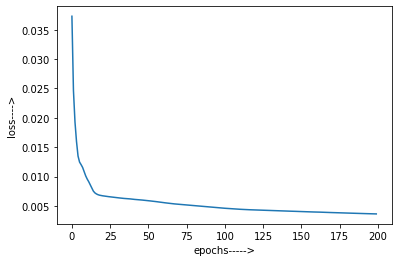

In [179]:
import matplotlib.pyplot as plt
plt.plot(l)
plt.ylabel('loss---->')
plt.xlabel('epochs----->')
plt.show()

In [180]:
loss_train=[]
for i in range(x_train.shape[0]):
  loss_train.append(loss_fn(autoencoder(x_train[i:i+1,:]),x_train[i:i+1,:]))
print(max(loss_train),min(loss_train))

tensor(0.0799, grad_fn=<DivBackward0>) tensor(6.5964e-06, grad_fn=<DivBackward0>)


In [181]:
x_train.shape,x_val.shape

(torch.Size([13449, 123]), torch.Size([11743, 123]))

Plot of loss for training set

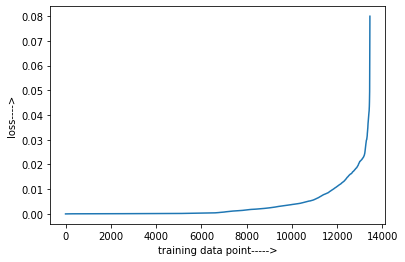

In [182]:
loss_train.sort()
plt.plot(loss_train)
plt.ylabel('loss---->')
plt.xlabel('training data point----->')
plt.show()

Plot of loss function for validation set

In [183]:
loss_val=[]
for i in range(x_val.shape[0]):
  loss_val.append(loss_fn(autoencoder(x_test[i:i+1,:-1]),x_test[i:i+1,:-1]))
print(max(loss_val),min(loss_val))

tensor(0.1089, grad_fn=<DivBackward0>) tensor(0.0021, grad_fn=<DivBackward0>)


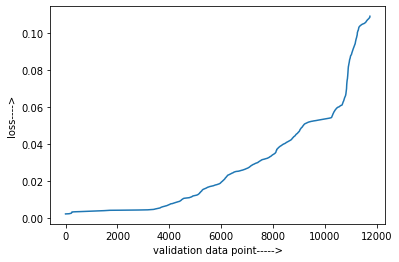

In [184]:
loss_val.sort()
plt.plot(loss_val)
plt.ylabel('loss---->')
plt.xlabel('validation data point----->')
plt.show()

In [185]:
#loss_threshold=loss_train[int(0.43*len(loss_train))]
loss_threshold=loss_val[int(0.43*len(loss_val))]

In [186]:
loss_threshold

tensor(0.0123, grad_fn=<DivBackward0>)

In [187]:
x_test.shape,x_train.shape

(torch.Size([22544, 124]), torch.Size([13449, 123]))

Plot of loss function for test set

In [188]:
loss_test=[]
for i in range(x_test.shape[0]):
  loss_test.append(loss_fn(autoencoder(x_test[i:i+1,:-1]),x_test[i:i+1,:-1]))
print(max(loss_test),min(loss_test))

tensor(0.1089, grad_fn=<DivBackward0>) tensor(0.0021, grad_fn=<DivBackward0>)


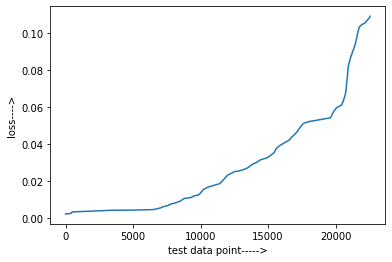

In [189]:
loss_test.sort()
plt.plot(loss_test)
plt.ylabel('loss---->')
plt.xlabel('test data point----->')
plt.show()

In [190]:
count=0
n_0=0
n_1=0
confusion_matrix=np.array([[0,0],
                           [0,0]])
for i in range(x_test.shape[0]):
  k=1 if loss_fn(autoencoder(x_test[i:i+1,:-1]),x_test[i:i+1,:-1])>loss_threshold else 0
  if k==x_test[i,-1]:
    if k==0:
      confusion_matrix[0,0]+=1
      n_0+=1
    else:
      confusion_matrix[1,1]+=1
      n_1+=1
    count+=1
  else:
    if k==0:
      confusion_matrix[1,0]+=1
      n_1+=1
    else:
      confusion_matrix[0,1]+=1
      n_0+=1
confusion_matrix[0,:]=confusion_matrix[0,:]
confusion_matrix[1,:]=confusion_matrix[1,:]
Precision=confusion_matrix[1,1]/confusion_matrix[:,1].sum()
Recall=confusion_matrix[1,1]/confusion_matrix[1,:].sum()

Results

In [191]:
print('Recall=',Recall*100)
print('Precision=',Precision*100)
print('F1 score=',200/((1/Recall)+(1/Precision)))
print('accuracy=',100*count/x_test.shape[0])
print('confusion_matrix \n [Predicted]\n',confusion_matrix,'[actual]')

Recall= 90.2127327982545
Precision= 90.70040739580068
F1 score= 90.45591280228152
accuracy= 89.16341376863024
confusion_matrix 
 [Predicted]
 [[ 8524  1187]
 [ 1256 11577]] [actual]
